In [1]:
import os
import json
import random
import numpy as np
from PIL import Image, ImageFilter, ImageOps

import torch
import torch.utils.data as data
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Cityscapes Dataset and Transforms

In [2]:
class Cityscapes(data.Dataset):
    """
    Modified from: https://pytorch.org/docs/master/_modules/torchvision/datasets/cityscapes.html#Cityscapes
    
    `Cityscapes <http://www.cityscapes-dataset.com/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory ``leftImg8bit``
            and ``gtFine`` or ``gtCoarse`` are located.
        split (string, optional): The image split to use, ``train``, ``test`` or ``val`` if mode="gtFine"
            otherwise ``train``, ``train_extra`` or ``val``
        mode (string, optional): The quality mode to use, ``gtFine`` or ``gtCoarse``
        target_type (string or list, optional): Type of target to use, ``instance``, ``semantic``, ``polygon``
            or ``color``. Can also be a list to output a tuple with all specified target types.
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.

    Examples:

        Get semantic segmentation target

        .. code-block:: python
            dataset = Cityscapes('./data/cityscapes', split='train', mode='gtFine',
                                 target_type='semantic')

            img, smnt = dataset[0]

        Get multiple targets

        .. code-block:: python
            dataset = Cityscapes('./data/cityscapes', split='train', mode='gtFine',
                                 target_type=['instance', 'color', 'polygon'])

            img, (inst, col, poly) = dataset[0]

        Validate on the "gtCoarse" set

        .. code-block:: python
            dataset = Cityscapes('./data/cityscapes', split='val', mode='gtCoarse',
                                 target_type='semantic')

            img, smnt = dataset[0]
    """

    def __init__(self, root, split='train', mode='gtFine', target_type='instance', transform=None):
        self.root = os.path.expanduser(root)
        self.images_dir = os.path.join(self.root, 'leftImg8bit', split)
        self.targets_dir = os.path.join(self.root, mode, split)
        self.transform = transform
        self.target_type = target_type
        self.split = split
        self.mode = mode
        self.images = []
        self.targets = []
        
        # Modifications to ignore trainId = [255, -1] as per Cityscapes label file and for training with correct index
        self.ignore_index = 255
        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
        self.n_classes = len(self.valid_classes)
        self.class_map = dict(zip(self.valid_classes, range(self.n_classes)))

        if mode not in ['gtFine', 'gtCoarse']:
            raise ValueError('Invalid mode! Please use mode="gtFine" or mode="gtCoarse"')

        if mode == 'gtFine' and split not in ['train', 'test', 'val']:
            raise ValueError('Invalid split for mode "gtFine"! Please use split="train", split="test"'
                             ' or split="val"')
        elif mode == 'gtCoarse' and split not in ['train', 'train_extra', 'val']:
            raise ValueError('Invalid split for mode "gtCoarse"! Please use split="train", split="train_extra"'
                             ' or split="val"')

        if not isinstance(target_type, list):
            self.target_type = [target_type]

        if not all(t in ['instance', 'semantic', 'polygon', 'color'] for t in self.target_type):
            raise ValueError('Invalid value for "target_type"! Valid values are: "instance", "semantic", "polygon"'
                             ' or "color"')

        if not os.path.isdir(self.images_dir) or not os.path.isdir(self.targets_dir):
            raise RuntimeError('Dataset not found or incomplete. Please make sure all required folders for the'
                               ' specified "split" and "mode" are inside the "root" directory')

        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            target_dir = os.path.join(self.targets_dir, city)
            for file_name in os.listdir(img_dir):
                target_types = []
                for t in self.target_type:
                    target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0],
                                                 self._get_target_suffix(self.mode, t))
                    target_types.append(os.path.join(target_dir, target_name))

                self.images.append(os.path.join(img_dir, file_name))
                self.targets.append(target_types)
                
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is a tuple of all target types if target_type is a list with more
            than one item. Otherwise target is a json object if target_type="polygon", else the image segmentation.
        """

        image = Image.open(self.images[index]).convert('RGB')
        
        targets = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
                
            # Modifications added to take care of ignore ids and updating ids
            elif t == 'semantic':
                temp = np.array(Image.open(self.targets[index][i])).astype(np.int32)
                temp = self._encode_target(temp)
                target = Image.fromarray(temp)
            else:
                target = np.array(Image.open(self.targets[index][i])).astype(np.int32)

            targets.append(target)

        target = tuple(targets) if len(targets) > 1 else targets[0]
        
        sample = {'image': image, 'label': target}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.images)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Split: {}\n'.format(self.split)
        fmt_str += '    Mode: {}\n'.format(self.mode)
        fmt_str += '    Type: {}\n'.format(self.target_type)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

    def _load_json(self, path):
        with open(path, 'r') as file:
            data = json.load(file)
        return data

    def _get_target_suffix(self, mode, target_type):
        if target_type == 'instance':
            return '{}_instanceIds.png'.format(mode)
        elif target_type == 'semantic':
            return '{}_labelIds.png'.format(mode)
        elif target_type == 'color':
            return '{}_color.png'.format(mode)
        else:
            return '{}_polygons.json'.format(mode)
        
    def _encode_target(self, mask):
        # Fill void class with value 255
        for void_class in self.void_classes:
            mask[mask == void_class] = self.ignore_index
            
        # Fill valid class with updated index
        for valid_class in self.valid_classes:
            mask[mask == valid_class] = self.class_map[valid_class]
            
        return mask

In [1]:
# Training dataset
dataset_root = './cityscapes'
train_dataset = Cityscapes(dataset_root, split='train', mode='gtFine', target_type='semantic')

# Sample Data For Transformations

In [4]:
# Image
img_path = './cityscapes/leftImg8bit/train/cologne/cologne_000115_000019_leftImg8bit.png'
img = Image.open(img_path)

# Label (for segmentation)
lab_path = './cityscapes/gtFine/train/cologne/cologne_000115_000019_gtFine_labelIds.png'
lab = Image.open(lab_path)

sample = {'image': img, 'label': lab}

# Normalize

https://github.com/jfzhang95/pytorch-deeplab-xception/blob/master/dataloaders/datasets/cityscapes.py

In [5]:
class Normalize(object):
    """
    Normalize an image (tensor) with mean and standard deviation. This
    should be just before ToTensor.
    """
    def __init__(self, mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Convert PIL data to NumPy array
        img = np.array(img).astype(np.float32)
        lab = np.array(lab).astype(np.float32)
        
        # Normalize img
        img /= 255.0
        img -= self.mean
        img /= self.std
        
        return {'image': img, 'label': lab}

# Array to Tensor 

### [H, W, C] -> [C, H, W]

In [6]:
class ToTensor(object):
    """
    Convert NumPy arrays to PyTorch tensors. This should be 
    the last transformation.
    """
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Convert PIL data to NumPy array
        img = np.array(img).astype(np.float32)
        lab = np.array(lab).astype(np.float32)
        
        # H x W x C -> C x H x W
        img = img.transpose((2, 0, 1))
        
        # Convert NumPy array to PyTorch tensor
        img = torch.from_numpy(img).float()
        lab = torch.from_numpy(lab).float()
        
        return {'image': img, 'label': lab}

# Random Horizontal Flip

In [7]:
class RandomHorizontalFlip(object):
    """
    Randomly horizontal flip image and label.
    
    NOTE: Returns data in PIL format
    """
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Horizontally flip
        if random.random() < self.p:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            lab = lab.transpose(Image.FLIP_LEFT_RIGHT)
            
        return {'image': img, 'label': lab}

# Random Rotate

In [8]:
class RandomRotate(object):
    """
    Randomly rotate image and label by angle in range -degree and 
    +degree range; degree is int
    
    NOTE: Returns data in PIL format
    """
    def __init__(self, degree=20):
        self.degree = degree
        
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Generate an angle in the range of degree
        angle = random.uniform(-1 * self.degree, self.degree)
        
        # Rotate image and label
        img = img.rotate(angle=angle, resample=Image.BILINEAR)
        lab = lab.rotate(angle=angle, resample=Image.NEAREST)
        
        return {'image': img, 'label': lab}

# Random Gaussian Blur

In [9]:
class RandomGaussianBlur(object):
    """
    Randomly apply Gaussian blur to image only.
    
    NOTE: Returns data in PIL format
    """
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Apply Gaussian blur to image
        if random.random() < self.p:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.random()))
            
        return {'image': img, 'label': lab}

# Fixed Resize

In [10]:
class FixedResize(object):
    """
    Resizes image and label to a fixed size.
    
    NOTE: Returns data in PIL format
    """
    def __init__(self, size=256):
        self.size = (size, size)
        
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Resize image and label
        img = img.resize(size=self.size, resample=Image.BILINEAR)
        lab = lab.resize(size=self.size, resample=Image.NEAREST)
        
        return {'image': img, 'label': lab}

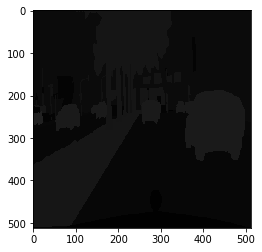

In [11]:
# Fixed resize test
func = FixedResize(512)
out = func(sample)
plt.imshow(out['label'])

# Fixed Scale Crop

In [12]:
class FixedScaleCrop(object):
    """
    Resizes image and label to a fixed size and then returns
    center cropped image and label
    
    NOTE: Returns data in PIL format
    """
    def __init__(self, crop_size=256):
        self.crop_size = crop_size
        
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Compute resize width and height
        width, height = img.size
        if width > height:
            resize_h = self.crop_size
            resize_w = int(resize_h * float(width) / height)
        else:
            resize_w = self.crop_size
            resize_h = int(resize_w * float(height) / width)
            
        # Resize image and label
        img = img.resize(size=(resize_w, resize_h), resample=Image.BILINEAR)
        lab = lab.resize(size=(resize_w, resize_h), resample=Image.NEAREST)
        
        # Center crop the resized image
        x1 = int(round(resize_w - self.crop_size) / 2.0)
        y1 = int(round(resize_h - self.crop_size) / 2.0)
        x2 = x1 + self.crop_size
        y2 = y1 + self.crop_size
        
        img = img.crop(box=(x1, y1, x2, y2))
        lab = lab.crop(box=(x1, y1, x2, y2))
        
        return {'image': img, 'label': lab}

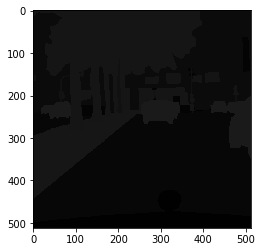

In [13]:
# Fixed scale crop test
func = FixedScaleCrop(512)
out = func(sample)

plt.imshow(out['label'])

# Fixed Scale Random Crop

In [14]:
class FixedScaleRandomCrop(object):
    """
    Resize image and label by a fixed scale, and then randomly 
    crop the resized image and label.
    
    fill: int, for ignoring purpose, as labelId 255 is to be ignored
    
    NOTE: Returns data in PIL format
    """
    def __init__(self, scale=512, crop_size=512, fill=255):
        self.scale = scale
        self.crop_size = crop_size
        self.fill = fill
    
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Compute resize width and height
        width, height = img.size
        if width > height:
            resize_h = self.scale
            resize_w = int(resize_h * float(width) / height)
        else:
            resize_w = self.scale
            resize_h = int(resize_w * float(height) / width)
            
        # Resize image and label
        img = img.resize(size=(resize_w, resize_h), resample=Image.BILINEAR)
        lab = lab.resize(size=(resize_w, resize_h), resample=Image.NEAREST)
            
        # Randomly crop the resized image and label
        x1 = random.randint(0, resize_w - self.crop_size)
        y1 = random.randint(0, resize_h - self.crop_size)
        x2 = x1 + self.crop_size
        y2 = y1 + self.crop_size
        
        img = img.crop(box=(x1, y1, x2, y2))
        lab = lab.crop(box=(x1, y1, x2, y2))
        
        return {'image': img, 'label': lab}

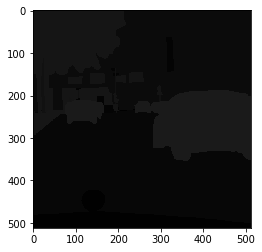

In [15]:
func = FixedScaleRandomCrop()
out = func(sample)
plt.imshow(out['label'])

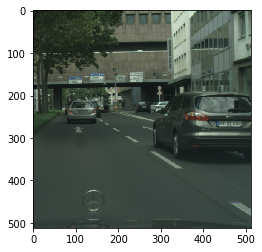

In [16]:
plt.imshow(out['image'])

# Random Scale Crop

In [17]:
class RandomScaleCrop(object):
    """
    Resize image and label by a random scale, and then randomly 
    crop the resized image and label.
    
    base_size must be > crop_size and multiple of 8
    
    fill: int, for ignoring purpose, as labelId 255 is to be ignored
    
    NOTE: Returns data in PIL format
    """
    def __init__(self, base_size, crop_size, fill=255):
        self.base_size = base_size
        self.crop_size = crop_size
        self.fill = fill
    
    def __call__(self, sample):
        # Extract PIL image and PIL label from dict
        img = sample['image']
        lab = sample['label']
        
        # Randomly scale short edge
        short_size = random.randint(int(self.base_size * 0.75), 
                                    int(self.base_size * 1.75))
        
        # Compute resize width and height
        width, height = img.size
        if width > height:
            resize_h = short_size
            resize_w = int(resize_h * float(width) / height)
        else:
            resize_w = short_size
            resize_h = int(resize_w * float(height) / width)
            
        # Resize image and label
        img = img.resize(size=(resize_w, resize_h), resample=Image.BILINEAR)
        lab = lab.resize(size=(resize_w, resize_h), resample=Image.NEAREST)
        
        # Pad image and label
        if short_size < self.crop_size:
            pad_h = self.crop_size - resize_h if resize_h < self.crop_size else 0
            pad_w = self.crop_size - resize_w if resize_w < self.crop_size else 0
            
            img = ImageOps.expand(img, border=(0, 0, pad_w, pad_h), fill=0)
            lab = ImageOps.expand(lab, border=(0, 0, pad_w, pad_h), fill=self.fill)
            
        # Randomly crop the resized image and label
        max_x = 1 if resize_w - self.crop_size < 0 else resize_w - self.crop_size
        max_y = 1 if resize_h - self.crop_size < 0 else resize_h - self.crop_size
        x1 = random.randint(0, max_x)
        y1 = random.randint(0, max_y)
        x2 = x1 + self.crop_size
        y2 = y1 + self.crop_size
        
        img = img.crop(box=(x1, y1, x2, y2))
        lab = lab.crop(box=(x1, y1, x2, y2))
        
        return {'image': img, 'label': lab}

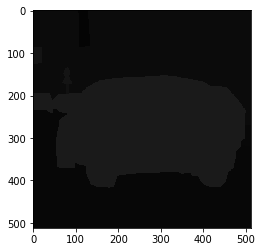

In [18]:
# Fixed scale crop test
func = RandomScaleCrop(640, 512) # Base size > crop size and multiple of 8
out = func(sample)
plt.imshow(out['label'])

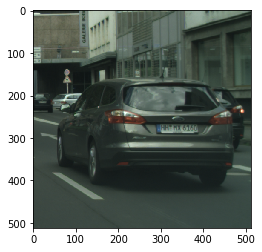

In [19]:
plt.imshow(out['image'])

# Composed Transforms

In [20]:
# Validation data
val_transforms = transforms.Compose([
    FixedResize(size=512),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensor()
])

dataset_root = './cityscapes'
val_dataset = Cityscapes(dataset_root, split='val', mode='gtFine', target_type='semantic', 
                         transform=val_transforms)
print(val_dataset)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

Dataset Cityscapes
    Number of datapoints: 500
    Split: val
    Mode: gtFine
    Type: ['semantic']
    Root Location: /home/ankoor/misc/segment/cityscapes
    Transforms (if any): Compose(
                         )



In [21]:
# Test
for i, sample in enumerate(val_loader):
    img = sample['image']
    lab = sample['label']
    if i == 1:
        break
        
print('image shape: ', img.shape, ' label shape: ', lab.shape)

image shape:  torch.Size([4, 3, 512, 512])  label shape:  torch.Size([4, 512, 512])


# Resize back to Original

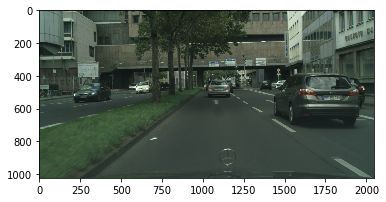

In [22]:
img_path = './cityscapes/leftImg8bit/train/cologne/cologne_000115_000019_leftImg8bit.png'
img = Image.open(img_path)
ori_w, ori_h = img.size
plt.imshow(img)

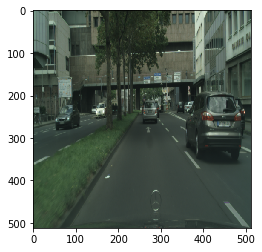

In [23]:
rs_img = img.resize(size=(512, 512), resample=Image.BILINEAR)
plt.imshow(rs_img)

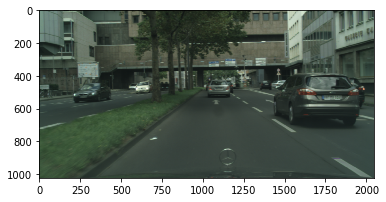

In [24]:
os_img = rs_img.resize(size=(ori_w, ori_h), resample=Image.BILINEAR)
plt.imshow(os_img)